In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
NEURAL_CONTROLLERS_DIR = os.environ['NEURAL_CONTROLLERS_DIR']
sys.path.append(NEURAL_CONTROLLERS_DIR)

## Llama 3.3 70B 4bit

In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds and methods
seeds = np.arange(5)
methods = ['rfm', 'linear', 'logistic']
model_name = 'llama_3.3_70b_4bit'
# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []
selected_test_metrics = {method: [] for method in methods}

hal_type = 'qa'
# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_results/{model_name}_it_{method}_seed_{s}_{hal_type}_val_metrics.pkl'
        path_test = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_results/{model_name}_it_{method}_seed_{s}_{hal_type}_test_metrics.pkl'
        
        # print(path_val, path_test)
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"Validation file not found: {path_val}")
            continue
        if not os.path.exists(path_test):
            print(f"Test file not found: {path_test}")
            continue
            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys (excluding any non-layer keys)
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Store trivial metrics if they exist
        if 'trivial_metrics' in val_results:
            trivial_metrics_val.append(val_results['trivial_metrics'])
        if 'trivial_metrics' in test_results:
            trivial_metrics_test.append(test_results['trivial_metrics'])
        
        # Collect per-layer metrics for validation
        for key in layers_val:
            if key not in d_val[method]:
                d_val[method][key] = []
            d_val[method][key].append(val_results[key])
        
        # Collect per-layer metrics for test
        for key in layers_test:
            if key not in d_test[method]:
                d_test[method][key] = []
            d_test[method][key].append(test_results[key])
        
        # Identify the layer with the highest validation accuracy
        if layers_val:  # Check if there are any layers
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            
            # Store all metrics for the selected test layer
            selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}
for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nSingle best layer:")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")


Single best layer:

RFM:
acc: 91.7138 ± 0.5128
precision: 0.9195 ± 0.0068
recall: 0.9146 ± 0.0095
f1: 0.9170 ± 0.0045
auc: 0.9731 ± 0.0011
mse: 0.0715 ± 0.0014

LINEAR:
acc: 94.0505 ± 0.2149
precision: 0.9189 ± 0.0045
recall: 0.9664 ± 0.0021
f1: 0.9420 ± 0.0019
auc: 0.9836 ± 0.0012
mse: 0.0510 ± 0.0013

LOGISTIC:
acc: 92.9547 ± 0.3151
precision: 0.9410 ± 0.0056
recall: 0.9167 ± 0.0111
f1: 0.9286 ± 0.0036
auc: 0.9834 ± 0.0013
mse: 12.0457 ± 0.8679


In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['linear', 'rfm', 'logistic']#, 'rfm_linear', 'linear_rfm']

# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:    
    for s in seeds:
        path = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_results/{model_name}_it_{method}_seed_{s}_{hal_type}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)
            
        # Store trivial accuracy if it exists
        if 'trivial_acc' in results:
            trivial_accs.append(results['trivial_acc'])
        
        # Store linear_agg results - store the entire dictionary
        if 'aggregation' in results:
            aggs_over_seeds[method].append(results['aggregation'])

# Compute and print metrics
print("\nAggregated Over layers:")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print metrics for all entries in linear_agg
    if aggs_over_seeds[method]:
        # Get all metric keys from the first result
        metric_keys = aggs_over_seeds[method][0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs_over_seeds[method]]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")


Aggregated Over layers:

LINEAR:
acc: 94.3808 ± 0.2132
precision: 0.9211 ± 0.0044
recall: 0.9708 ± 0.0018
f1: 0.9453 ± 0.0019
auc: 0.9849 ± 0.0016
mse: 0.0483 ± 0.0015

RFM:
acc: 93.2049 ± 0.2540
precision: 0.9195 ± 0.0049
recall: 0.9471 ± 0.0047
f1: 0.9331 ± 0.0029
auc: 0.9761 ± 0.0032
mse: 0.0521 ± 0.0016

LOGISTIC:
acc: 93.0048 ± 0.3554
precision: 0.9400 ± 0.0106
recall: 0.9192 ± 0.0170
f1: 0.9293 ± 0.0042
auc: 0.9849 ± 0.0016
mse: 27.1827 ± 8.1146


## Judge models

In [8]:

seeds = np.arange(5)
hal_type = 'general'
judge_types = ['llama', 'openai']
judge_models = ['llama_3.3_70b_4bit_it', 'gpt-4o']

# Dictionary to store accumulated metrics
accumulated_metrics = {}
# Iterate over seeds
for judge_type, judge_model in zip(judge_types, judge_models):
    for seed in seeds:
        with open(f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_results/{judge_type}_{judge_model}_{hal_type}_seed_{seed}_metrics.pkl', 'rb') as f:
            llama_results = pickle.load(f)
            
            # Initialize accumulated_metrics with the first seed's metrics
            if not accumulated_metrics:
                accumulated_metrics = {metric: [] for metric in llama_results.keys()}
                
            # Accumulate metrics for each seed
            for metric, val in llama_results.items():
                accumulated_metrics[metric].append(val)

    # Calculate and print averages
    print('-' * 30)
    print('{} {} (averaged over seeds)'.format(judge_model, judge_type))
    print('-' * 30)
    for metric, values in accumulated_metrics.items():
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")


------------------------------
llama_3.3_70b_4bit_it llama (averaged over seeds)
------------------------------
acc: 60.3461 ± 0.4021
precision: 0.3264 ± 0.0111
recall: 0.1942 ± 0.0038
f1: 0.2434 ± 0.0031
auc: 0.4945 ± 0.0079
mse: 0.3638 ± 0.0053
------------------------------
gpt-4o openai (averaged over seeds)
------------------------------
acc: 53.4783 ± 6.8928
precision: 0.3264 ± 0.0094
recall: 0.3910 ± 0.1970
f1: 0.3316 ± 0.0883
auc: 0.4909 ± 0.0092
mse: 0.4264 ± 0.0629


# Layer-wise plots

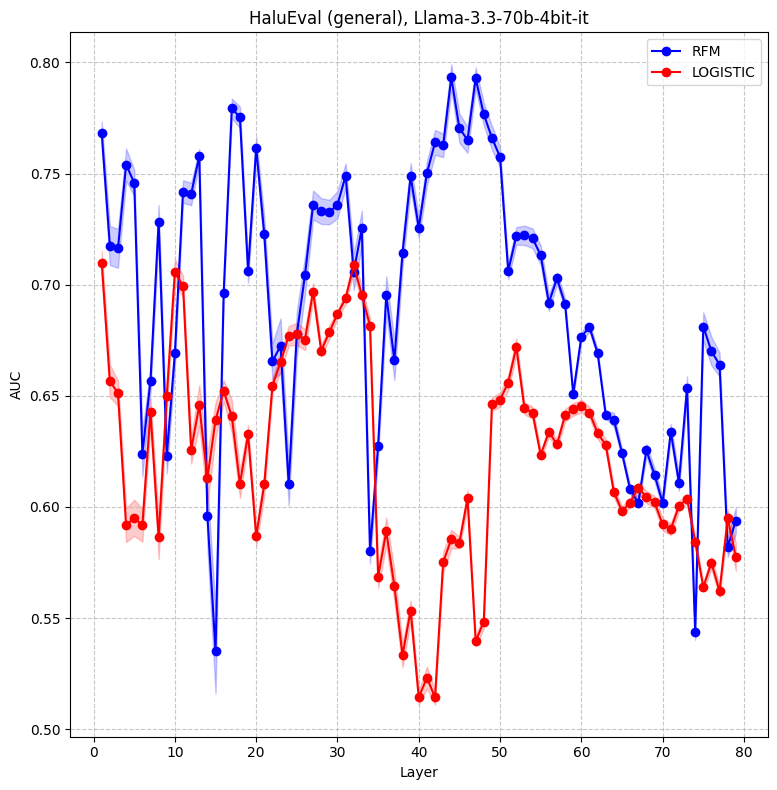

In [9]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds
seeds = np.arange(5)
methods = ['rfm', 'logistic']
models = ['llama_3.3_70b_4bit_it']
metric = 'auc'
# Initialize dictionaries to store results
all_results = {}
hal_type = 'general'
for model in models:
    all_results[model] = {
        'test': {method: {} for method in methods}
    }

    # Load data for each method
    for method in methods:
        # Process each seed
        for s in seeds:
            # Path for test metrics
            path_test = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_results/{model}_{method}_seed_{s}_{hal_type}_test_metrics.pkl'
            
            # Check if file exists
            if not os.path.exists(path_test):
                print(f"File not found: {path_test}")
                continue
                
            # Load test results
            with open(path_test, 'rb') as f:
                test_results = pickle.load(f)
            
            # Get layer keys (excluding non-dict entries)
            layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
            
            # Collect per-layer metrics
            for key in layers_test:
                if key not in all_results[model]['test'][method]:
                    all_results[model]['test'][method][key] = []
                all_results[model]['test'][method][key].append(test_results[key][metric])

# Calculate average accuracies per layer
avg_results = {}
for model in models:
    avg_results[model] = {}
    for method in methods:
        avg_results[model][method] = {}
        for layer, accs in all_results[model]['test'][method].items():
            if accs:  # Check if we have data for this layer
                avg_results[model][method][layer] = {
                    'mean': np.mean(accs),
                    'std': np.std(accs)
                }


# Plot the results
plt.figure(figsize=(15, 8))

# Define colors and alpha values for shading
colors = {'rfm': 'blue', 'logistic': 'red'}
alpha_fill = 0.2  # Alpha transparency for the shaded region

for i, model in enumerate(models):
    plt.subplot(1, 2, i+1)
    
    for method in methods:
        layer_data = avg_results[model][method]
        if layer_data:
            # Sort layers by their numerical value
            layers = sorted([int(layer) for layer in layer_data.keys() if isinstance(layer, int)])
            
            # Extract mean and std for plotting
            means = [layer_data[layer]['mean'] for layer in layers if layer in layer_data]
            stds = [layer_data[layer]['std'] for layer in layers if layer in layer_data]
            
            # Center the layers
            layers = [x+len(layers)+1 for x in layers]

            # Plot the mean line
            plt.plot(layers, means, label=method.upper(), marker='o', color=colors[method])
            
            # Add shaded error region
            plt.fill_between(
                layers, 
                [m - s for m, s in zip(means, stds)],  # lower bound
                [m + s for m, s in zip(means, stds)],  # upper bound
                color=colors[method], 
                alpha=alpha_fill
            )
    
    model_str = model.replace("_", "-")
    model_str = model_str[0].upper() + model_str[1:]
    plt.title(f'HaluEval ({hal_type}), {model_str}')
    plt.xlabel('Layer')
    plt.ylabel(f'{metric.upper()}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

plt.savefig(f'plots/he_{hal_type}_test_{metric}_across_layers.pdf', format='pdf')
plt.show()